In [221]:
# Imports
import math
import random
import pandas as pd

In [231]:
def generate_seed_points(seq_points, n_clusters):
  s_x = [x for (x, y) in seq_points]
  s_y = [y for (x, y) in seq_points]
  n_p = len(seq_points)
  x_max = max(s_x)
  x_min = min(s_x)
  y_max = max(s_y)
  y_min = min(s_y)
  size_x = (x_max - x_min)/n_clusters
  size_y = (y_max - y_min)/n_clusters
  n_macro = n_clusters * n_clusters
  delta = average_density(seq_points, n_macro)
  print("x_max", x_max, "x_min", x_min)
  print("y_max", y_max, "y_min", y_min)
  print("size_x", size_x, "size_y", size_y)
  print("number of macroblocks", n_macro, "Average Density", delta)
  s_higher = []

  for i in range(n_clusters):
    x_low = x_min + (i * size_x)
    x_high = x_low + size_x
    x_mid = (x_high + x_low) / 2
    for j in range(n_clusters):
      y_low = y_min + (j * size_y)
      y_high = y_low + size_y
      y_mid = (y_low + y_high)/2
      n_p = points_in_macroblocks(seq_points, x_low, y_low, x_high, y_high)
      print("points in macroblock for", i, j, "is", n_p)
      if n_p > delta:
        s_higher.append((x_mid, y_mid))
    
  print("s_higher", s_higher)
  s_seed = []
  for i in range(n_clusters):
    next_seed = randomly_select(s_higher)
    s_seed.append(next_seed)
    s_higher.remove(next_seed)
  
  radius = min(size_x, size_y)/n_clusters

  print("s_seed", s_seed, "radius", radius)
  radius = radius_from_centroid(n_clusters, s_seed, radius)

  print("radius", radius)
  return (s_seed, radius)

In [223]:
def radius_from_centroid(n_clusters, s_seed, radius):
    for i in range(n_clusters):
      (x_i, y_i) = s_seed[i]
      for j in range(n_clusters):
        if not i == j:
          (x_j, y_j) = s_seed[j]
          d_i_j = math.sqrt(math.pow(x_i - x_j, 2) + math.pow(y_i - y_j, 2))
          print("distance", d_i_j)
          if d_i_j > 2*radius:
            radius = d_i_j/2
    return radius

In [224]:
def average_density(seq_points, n_macro):
  return len(seq_points)/n_macro

In [225]:
def randomly_select(s_higher):
  rand_index = random.randint(0, len(s_higher)-1)
  # print("s_higher", s_higher, "rand_index", rand_index)
  return s_higher[rand_index]

In [226]:
def points_in_macroblocks(seq_points, x_low, y_low, x_high, y_high):
  # print("x_low", x_low, "y_low", y_low, "x_high", x_high, "y_high", y_high)
  n_macro = 0
  for (x,y) in seq_points:
    # print("x", x, "y", y)
    if (x >= x_low) and (x < x_high) and (y >= y_low) and (y < y_high):      
      n_macro += 1
  # print("n_macro", n_macro)
  return n_macro

In [229]:
def k_means_clustering(seq_points, n_clusters, max_iter, epi):
  n_p = len(seq_points)
  (s_seed, radius) = generate_seed_points(seq_points, n_clusters)
  # s_seed = [(1,1), (6,8)]
  # radius = 3
  print("s_seed", s_seed, "radius", radius)
  count = 1
  stabilized = False
  
  while((count <= max_iter) and not stabilized):
    print("In Iter", count, "seed points/centroids are", s_seed, "radius is", radius)
    clusters = [[] for x in range(n_clusters)]
    outliers = seq_points.copy()
    seq_points_copy = seq_points.copy()
    s_out = seq_points
    centroids_new = []
    for i in range(n_clusters):
      print(f"In iter {i} and points in cluster are {clusters} and outliers are {outliers}")
      (cx, cy) = s_seed[i]
      sp = 0
      while sp < len(seq_points_copy):
          (x, y) = seq_points_copy[sp]
          d_i_j = math.sqrt(math.pow(cx - x, 2) + math.pow(cy - y, 2))
          # print(f"distance of ({x},{y}) from centorid ({cx}, {cy}) is {d_i_j}")
          if d_i_j < radius:
              # print(f"Adding ({x},{y}) to cluster {i} and removing from outliers")
              clusters[i].append((x, y))
              seq_points_copy.remove((x, y))
              # print("clusters contenct", clusters, "outliers content", outliers)
              if (x, y) in outliers:
                  outliers.remove((x, y))
              # print("points in cluster", i, "is", clusters[i])
          else:
              sp += 1
      
      cx_i_new = sum([x for (x, y) in clusters[i]])/len(clusters[i])
      cy_i_new = sum([y for (x, y) in clusters[i]])/len(clusters[i])
      centroids_new.append((cx_i_new, cy_i_new))
      print("cluster", i, "new centroid", (cx_i_new, cy_i_new))

    stabilized = True
    for i in range(len(clusters)):
      (cx, cy) = s_seed[i]
      (cx_new, cy_new) = centroids_new[i]
      centroid_shift = math.sqrt(math.pow(cx - cx_new, 2) + math.pow(cy - cy_new, 2))
      print("Centroid shift", centroid_shift)
      if centroid_shift > epi:
        stabilized = False
        s_seed[i] = centroids_new[i]
    
    # New radius from new seed points
    radius = radius_from_centroid(n_clusters, s_seed, radius)
    print("new radius after ", i, "iter is", radius)

    print()
    count += 1

  #Cluster Radius calc
  radius_new = []
  for c in range(len(clusters)):
    radius_cluster = []
    for p in clusters[c]:
      (x, y) = p
      (new_centroid_x, new_centroid_y) = s_seed[c]
      d = math.sqrt(math.pow(new_centroid_x - x, 2) + math.pow(new_centroid_y - y, 2))
      radius_cluster.append(d)
    radius_new.append(max(radius_cluster))

  print(radius_new)
  print("Final clusters")
  for i in range(len(clusters)):
    print("size of cluster", i, "is", len(clusters[i]))
    if len(clusters[i]) < 10:
      display(clusters[i])
  print("Final outliers")
  print("size of outliers", len(outliers))
  if len(outliers) < 10:
    display(outliers)
  return clusters, outliers, s_seed, radius, radius_new

In [232]:
df = pd.read_excel("/content/sample_data/K-means_programming_assignment_data.xlsx")
print(df.head())
x = list(df.get('X'))
y = list(df.get('Y'))
seq_points = []
print(len(df))

for (i, j) in zip(x, y):
  seq_points.append((i, j))

print(seq_points)

n_clusters = int(input("Enter number of clusters to be formed"))
max_iter = int(input("Enter max iterations to be performed"))
epi = 1
clusters, outliers, s_seed, final_radius, radius_new = k_means_clustering(seq_points, n_clusters, max_iter, epi)

   X  Y
0  1  2
1  2  3
2  2  2
3  5  6
4  6  7
8
[(1, 2), (2, 3), (2, 2), (5, 6), (6, 7), (6, 8), (7, 11), (1, 1)]
Enter number of clusters to be formed2
Enter max iterations to be performed10
x_max 7 x_min 1
y_max 11 y_min 1
size_x 3.0 size_y 5.0
number of macroblocks 4 Average Density 2.0
points in macroblock for 0 0 is 4
points in macroblock for 0 1 is 0
points in macroblock for 1 0 is 0
points in macroblock for 1 1 is 3
s_higher [(2.5, 3.5), (5.5, 8.5)]
s_seed [(2.5, 3.5), (5.5, 8.5)] radius 1.5
distance 5.830951894845301
distance 5.830951894845301
radius 2.9154759474226504
s_seed [(2.5, 3.5), (5.5, 8.5)] radius 2.9154759474226504
In Iter 1 seed points/centroids are [(2.5, 3.5), (5.5, 8.5)] radius is 2.9154759474226504
In iter 0 and points in cluster are [[], []] and outliers are [(1, 2), (2, 3), (2, 2), (5, 6), (6, 7), (6, 8), (7, 11), (1, 1)]
cluster 0 new centroid (1.6666666666666667, 2.3333333333333335)
In iter 1 and points in cluster are [[(1, 2), (2, 3), (2, 2)], []] and out

[(1, 2), (2, 3), (2, 2), (1, 1)]

size of cluster 1 is 3


[(5, 6), (6, 7), (6, 8)]

Final outliers
size of outliers 1


[(7, 11)]

In [239]:
df = pd.read_csv("/content/sample_data/k-means-data.csv")
x = list(df.get('X'))
y = list(df.get('Y'))
seq_points = []
print(len(df))

for (i, j) in zip(x, y):
  seq_points.append((i, j))

n_clusters = int(input("Enter number of clusters to be formed"))
max_iter = int(input("Enter max iterations to be performed"))
epi = 0.1
clusters, outliers, s_seed, final_radius, radius_new = k_means_clustering(seq_points, n_clusters, max_iter, epi)

1500
Enter number of clusters to be formed3
Enter max iterations to be performed100
x_max 1.68 x_min -1.92
y_max 2.24 y_min -1.65
size_x 1.2 size_y 1.2966666666666666
number of macroblocks 9 Average Density 166.66666666666666
points in macroblock for 0 0 is 270
points in macroblock for 0 1 is 188
points in macroblock for 0 2 is 64
points in macroblock for 1 0 is 94
points in macroblock for 1 1 is 38
points in macroblock for 1 2 is 244
points in macroblock for 2 0 is 405
points in macroblock for 2 1 is 107
points in macroblock for 2 2 is 88
s_higher [(-1.3199999999999998, -1.0016666666666665), (-1.3199999999999998, 0.29500000000000004), (-0.12, 1.5916666666666668), (1.08, -1.0016666666666665)]
s_seed [(-1.3199999999999998, -1.0016666666666665), (-0.12, 1.5916666666666668), (1.08, -1.0016666666666665)] radius 0.39999999999999997
distance 2.8575125157692267
distance 2.4
distance 2.8575125157692267
distance 2.857512515769227
distance 2.4
distance 2.857512515769227
radius 1.4287562578846136

[]

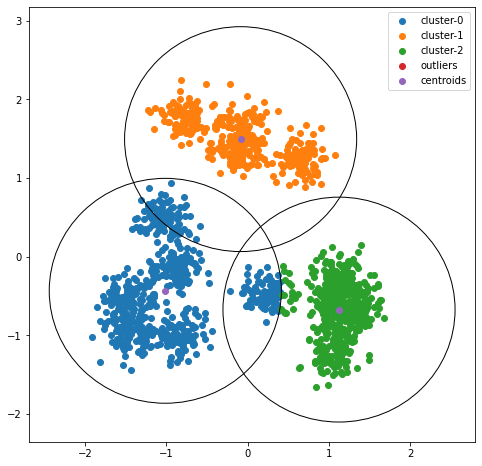

In [240]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 1, figsize=(8, 8))

for i in range(len(clusters)):
  c = clusters[i]
  axes.scatter([x for (x,y) in c], [y for (x,y) in c], label='cluster-'+str(i))
  cir = plt.Circle(s_seed[i], final_radius, fill=False)
  axes.add_patch(cir)

axes.scatter([x for (x,y) in outliers], [y for (x,y) in outliers], label='outliers')
axes.scatter([x for (x,y) in s_seed], [y for (x,y) in s_seed], label='centroids')
plt.legend()
plt.show()

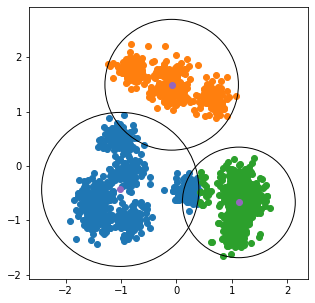

In [241]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(figsize=(5, 5))

for i in range(len(clusters)):
  c = clusters[i]
  axes.scatter([x for (x,y) in c], [y for (x,y) in c])
  cir = plt.Circle(s_seed[i], radius_new[i], fill=False)
  axes.add_patch(cir)


axes.scatter([x for (x,y) in outliers], [y for (x,y) in outliers])
axes.scatter([x for (x,y) in s_seed], [y for (x,y) in s_seed])
plt.show()